By:
Robert Bangiyev, Lester Kong, Kenny Xia, and Jiayao Zhou

In [1]:
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

We found two datasets, [one](https://www.kaggle.com/gregorut/videogamesales) with fewer overall rows, but with more values in for features that counted, and [one](https://www.kaggle.com/ashaheedq/video-games-sales-2019) with a feature we found would help us with what we were trying to do.

In [2]:
mainDSet = pd.read_csv('vgsales.csv')
additionalDSet = pd.read_csv('vgsales-12-4-2019-short.csv')

First thing we did was to clean the additional dataset to make it easier to extract the Developer feature from it

In [ ]:
additionalDSetAltered = additionalDSet[['Name', 'Developer', 'Platform', 'Year', 'Genre']]

In [ ]:
additionalDSetAltered = additionalDSetAltered.drop_duplicates(subset=['Name', 'Developer'])
additionalDSetAltered.head(3)

,Name,Developer,Platform,Year,Genre
0,Wii Sports,Nintendo EAD,Wii,2006.0,Sports
1,Super Mario Bros.,Nintendo EAD,NES,1985.0,Platform
2,Mario Kart Wii,Nintendo EAD,Wii,2008.0,Racing


Next, we extracted the Developer feature from the additional dataset by merging it with our main dataset

In [ ]:
result_test = pd.merge(mainDSet,additionalDSetAltered,on=["Name","Platform", "Year", "Genre"],how="left")
result_test

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,Nintendo EAD
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,Nintendo EAD
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,Nintendo EAD
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,Nintendo EAD
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16608,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01,NaN
16609,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01,NaN
16610,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01,NaN
16611,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01,Bitfield GmbH


Here, we stumbled upon an issue that arose with this merge. The original main dataset contained only 16598 rows, but this new dataset contained 16613. After running a few tests to look for what was causing the issue, we came to a realization. The additional dataset which we were trying to extract the feature from had developers in different entries for the same game and console, resulting in the Ace Combat 5: The Unsung War example below

In [ ]:
additionalDSetAltered[additionalDSetAltered['Name'] == 'Ace Combat 5: The Unsung War']

,Name,Developer,Platform,Year,Genre
1232,Ace Combat 5: The Unsung War,Namco,PS2,2004.0,Simulation
21764,Ace Combat 5: The Unsung War,Project ACES,PS2,2004.0,Simulation


In [ ]:
result_test[result_test['Name'] == 'Ace Combat 5: The Unsung War']

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer
1044,1046,Ace Combat 5: The Unsung War,PS2,2004.0,Simulation,Sony Computer Entertainment Europe,0.88,0.34,0.32,0.18,1.71,Namco
1045,1046,Ace Combat 5: The Unsung War,PS2,2004.0,Simulation,Sony Computer Entertainment Europe,0.88,0.34,0.32,0.18,1.71,Project ACES


Despite both games being of the same console, they existed as two separate entries in the additional dataset, and when this dataset was merged with the main dataset, it resulted in rows being added, about 15 to be exact. To amend this issue, we decided that the best course of action would be to combine the rows where all features besides the Developer had the same values into a single row, with the different Developer values separated by a "/". This was done because it appears as though that was already how the dataset handled multiple developers for a single entry, as can be seen below.

In [ ]:
result_test[result_test['Developer'].str.split('/').str.len() > 1]

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer
42,43,Mario Kart 7,3DS,2011.0,Racing,Nintendo,4.74,3.91,2.67,0.89,12.21,Nintendo EAD / Retro Studios
265,266,Metal Gear Solid 3: Snake Eater,PS2,2004.0,Action,Konami Digital Entertainment,1.46,0.00,0.83,1.93,4.23,KCEJ / Kojima Productions
274,275,Street Fighter IV,PS3,2009.0,Fighting,Capcom,2.02,1.06,0.58,0.53,4.19,Capcom / Dimps Corporation
301,302,Left 4 Dead 2,X360,2009.0,Shooter,Electronic Arts,2.67,0.89,0.05,0.37,3.99,Certain Affinity / Valve Software
369,370,Left 4 Dead,X360,2008.0,Shooter,Electronic Arts,2.66,0.50,0.05,0.30,3.52,Certain Affinity / Valve Software
...,...,...,...,...,...,...,...,...,...,...,...,...
15589,15578,My Hero: Doctor,DS,2009.0,Action,Majesco Entertainment,0.02,0.00,0.00,0.00,0.02,Game Life / Dream On Studio
15778,15767,Soul Eater: Monotone Princess,Wii,2008.0,Action,Square Enix,0.00,0.00,0.02,0.00,0.02,Square Enix / Bones
16140,16129,Monster Rancher Advance 2,GBA,2002.0,Simulation,Tecmo Koei,0.01,0.00,0.00,0.00,0.01,Tecmo / Graphic Research
16367,16356,G1 Jockey 4 2008,PS3,2008.0,Sports,Tecmo Koei,0.00,0.01,0.00,0.00,0.01,Koei/Inis


After some attempts using .groupby from the pandas library, we realized that because we were grouping by all features besides Developer, and the features Year and Publisher had missing values, those missing values were causing rows to be deleted. A workaround we found for this was to temporarily set all the rows with missing values for Year to 0 and missing values for Publisher to an empty space, just so rows were not lost in the process. Additionally, we had to do the same to the Developer feature as what we did to the Publisher feature, which was to set all its missing values to an empty space.

In [ ]:
result_test.loc[result_test['Year'].isna(), ['Year']] = 0
result_test.loc[result_test['Publisher'].isna(), ['Publisher']] = ""
result_test.loc[result_test['Developer'].isna(), ['Developer']] = ""

We were now ready to proceed without fear of losing rows

In [ ]:
result_test = result_test.groupby(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'])['Developer'].apply(lambda x: '/'.join(x)).reset_index()

In [ ]:
result_test[result_test['Name'] == 'Ace Combat 5: The Unsung War']

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Developer
1044,1046,Ace Combat 5: The Unsung War,PS2,2004.0,Simulation,Sony Computer Entertainment Europe,0.88,0.34,0.32,0.18,1.71,Namco/Project ACES


Finally, we reordered the columns



In [ ]:
final = result_test[['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'Developer', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]

In [ ]:
final.to_csv('integratedvgsales.csv', index=False)

In [ ]:
final.loc[final['Year'] == 0, 'Year'] = np.nan

In [ ]:
df = pd.read_csv('integratedvgsales.csv')

In [ ]:
newdf = df[df['Year'] != 0]

Text(0.5, 1.0, 'Global Sales in millions for each Year')

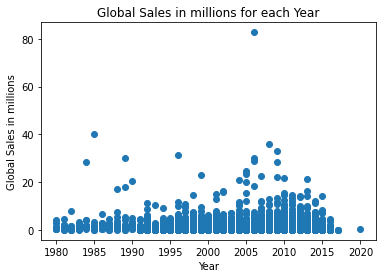

In [ ]:
plt.scatter('Year', 'Global_Sales', data=newdf)
plt.xlabel('Year')
plt.ylabel('Global Sales in millions')
plt.title('Global Sales in millions for each Year')

In [ ]:
newdf[newdf['Global_Sales'] > 80]

,Rank,Name,Platform,Year,Genre,Publisher,Developer,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,Nintendo EAD,41.49,29.02,3.77,8.46,82.74


Text(0.5, 1.0, 'Global Sales in millions for each Year')

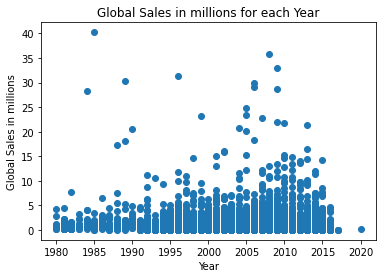

In [ ]:
temp = newdf[newdf['Global_Sales'] < 80]
plt.scatter(temp['Year'], temp['Global_Sales'])
plt.xlabel('Year')
plt.ylabel('Global Sales in millions')
plt.title('Global Sales in millions for each Year')

Text(0.5, 1.0, 'Global Sales for each Game for each Year')

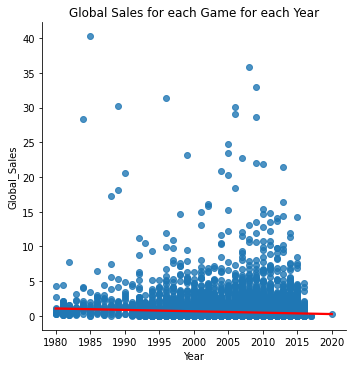

In [ ]:
sns.lmplot(x='Year', y='Global_Sales', data=temp, fit_reg=True, line_kws={"color": "red"});
plt.title('Global Sales for each Game for each Year')

In [ ]:
genreDf = df.groupby(['Genre'])['Global_Sales'].mean().reset_index()
genreDfMed = df.groupby(['Genre'])['Global_Sales'].median().reset_index()

Text(0.5, 1.0, 'Average Global Sales for each Genre')

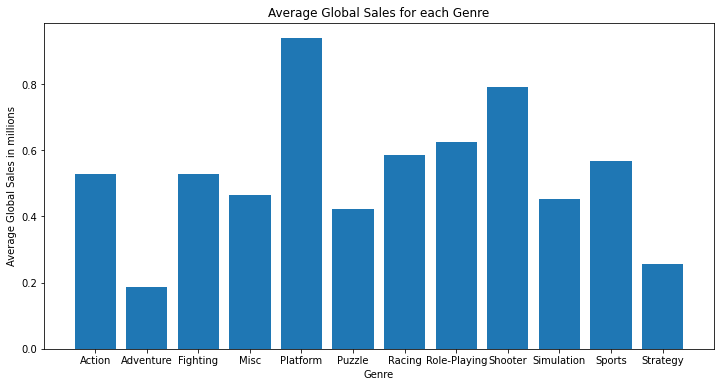

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(genreDf['Genre'], genreDf['Global_Sales'])
plt.xlabel('Genre')
plt.ylabel('Average Global Sales in millions')
plt.title('Average Global Sales for each Genre')

Text(0.5, 1.0, 'Median Global Sales for each Genre')

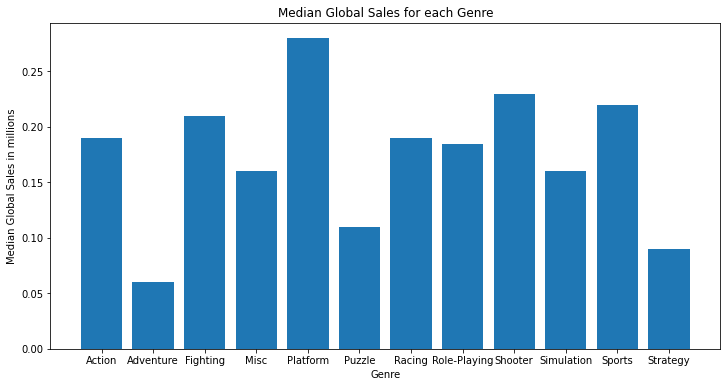

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(genreDfMed['Genre'], genreDfMed['Global_Sales'])
plt.xlabel('Genre')
plt.ylabel('Median Global Sales in millions')
plt.title('Median Global Sales for each Genre')

In [ ]:
from sklearn import tree
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

Importing all possible algorithms to be used as well as libraries to test accuracy of our models

In [ ]:
cols = ['Platform',	'Genre',	'Developer',	'Publisher']
colsTwo = ['Platform', 'Genre']
colsThree = ['Platform',	'Genre',	'Publisher']

The columns which we will create dummies for as they are categorical and sklearn libraries require numerical inputs

The second column will not include developer and publisher as we will create a testing set without them

In [ ]:
stuff = pd.get_dummies(final, columns=cols, drop_first=True)
stuffTwo = pd.get_dummies(final,columns=colsTwo, drop_first=True)
stuffThree = pd.get_dummies(final, columns=colsThree, drop_first=True)

Using the get_dummies function to turn our categorical values 
into numerical ones so that we can use them to train our model.

In [ ]:
X = stuff.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'])
XTwo = stuffTwo.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales','Developer','Publisher'])
XThree = stuffThree.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales','Developer'])

We will be dropping these columns because they won't be necessary to compute the estimated sales.

We will be left with: Platform, Year, Genre, Publisher, Developer

For our second testing and training set, we will drop publisher and developer to see if we got better results 

In [ ]:
y = final['Global_Sales']
yTwo = final['Global_Sales']
yThree = final['Global_Sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(XTwo, yTwo, test_size=0.2)

Splitting the data into a training set and a testing set, 20% of the dataset will be used as a testing set while the other 80% will be used to train

In [ ]:
X_train.fillna(X_train['Year'].median(), inplace = True)
X_test.fillna(X_test['Year'].median(), inplace = True)
X_train_two.fillna(X_train_two['Year'].median(), inplace = True)
X_test_two.fillna(X_test_two['Year'].median(), inplace = True)

There are missing values for year in our datasets, so we will replace them with the mode of that dataset. We make sure to use the mode of that dataset so that no data leakage happens.

In [ ]:
linear = LinearRegression()
linear_two = LinearRegression()
decision = tree.DecisionTreeRegressor()
decision_two = tree.DecisionTreeRegressor()
forest = RandomForestRegressor()
forest_two = RandomForestRegressor()
sgd = SGDRegressor()
sgd_two = SGDRegressor()

This is where we create the model. We decided to create multiple models to see which one gives the best result as we had trouble finding an algorithm that fit well.

In [ ]:
linear.fit(X_train, y_train)
decision.fit(X_train,y_train)
linear_two.fit(X_train_two, y_train_two)
decision_two.fit(X_train_two,y_train_two)
forest.fit(X_train, y_train)
forest_two.fit(X_train_two,y_train_two)
sgd.fit(X_train, y_train)
sgd_two.fit(X_train_two, y_train_two)

SGDRegressor()

This is where we train our models with their respective datasets. The ones with two are the ones training on datasets without developer and publisher.

In [ ]:
linear_prediction = linear.predict(X_test)
decision_prediction = decision.predict(X_test)
forest_prediction = forest.predict(X_test)
sgd_prediction = sgd.predict(X_test)

linear_prediction_two = linear_two.predict(X_test_two)
decision_prediction_two = decision_two.predict(X_test_two)
forest_prediction_two = forest_two.predict(X_test_two)
sgd_prediction_two = sgd_two.predict(X_test_two)

Now that the models have been created, we use it to predict on the testing part of the dataset.

In [ ]:
linear_r_score = r2_score(y_test, linear_prediction)
decision_score = r2_score(y_test, decision_prediction)
forest_score = r2_score(y_test, forest_prediction)
sgd_score = r2_score(y_test,sgd_prediction)

linear_r_score_two = r2_score(y_test_two, linear_prediction_two)
decision_score_two = r2_score(y_test_two, decision_prediction_two)
forest_score_two = r2_score(y_test_two, forest_prediction_two)
sgd_score_two = r2_score(y_test_two, sgd_prediction_two)

Since our target dataset is continuous, we used r2 score to determine the accuraccy of our models. The closer it is to 1 or 100% the more accurate our model is.

In [ ]:
d = {'Actual': y_test_two, 'Predicted': linear_prediction_two}
compare = pd.DataFrame(data=d)
compare

,Actual,Predicted
1198,1.55,0.754298
15315,0.02,0.247369
13647,0.04,0.770268
15805,0.02,0.417227
1468,1.33,0.940004
...,...,...
3629,0.55,0.525557
8728,0.15,0.410777
13431,0.05,0.667750
9695,0.12,0.454854


I think Linear Regression doesn't do too well because the sales in the data set aren't linear, they drop off really quickly, closer to exponential than linear with a lot of sales being 0 to 1 

Model accuracies so far:

LinearRegression() - pretty bad, accuracy is a really large(?) negative number. Without developer and publisher features, LinearRegression averages about 5% accuracy, but everything else has negative accuracy.

tree.DecisionTreeRegressor() - fluctuates a lot goes from ~ -20 to 30 % (sometimes is a very large negative number ~70% still not as high as linear regression though)

RandomForestRegressor() - I think this one is a decision tree but with a bunch of small ones (?) supposed to be more accurate with a big data set, but this one takes a VERY long time to run so I don't have a lot of results to to work with. First test: 28% Second test: 30% Third test: -3% Fourth test: 0% Fifth test: 27%

SGDRegressor() - Fast, but very large negative number like LinearRegression.

In [ ]:
model_d = {'Name' : ['Linear Regression','Decision Tree', 'Random Forest Regressor', 'SGDRegressor','Linear Regression w/o',
                     'Decision Tree w/o', 'Forest w/o', 'SGDRegressor w/o'], 
           'R_score (Percentage)' : [linear_r_score * 100, decision_score * 100, forest_score * 100, sgd_score * 100, 
                                     linear_r_score_two * 100, decision_score_two * 100, 
                                     forest_score_two * 100, sgd_score_two * 100 ]}
model_compare = pd.DataFrame(data=model_d)
model_compare

,Name,R_score (Percentage)
0,Linear Regression,-1.219429e+21
1,Decision Tree,-4.305908e+01
2,Random Forest Regressor,3.074513e+00
3,SGDRegressor,-3.900729e+31
4,Linear Regression w/o,3.553076e+00
5,Decision Tree w/o,-2.605531e+01
6,Forest w/o,-1.809363e+01
7,SGDRegressor w/o,-1.005120e+32


The models we used and their respective R2 scores.

In [ ]:
linear_coef = pd.DataFrame(linear_two.coef_,  columns=['Coefficients'], index=X_train_two.columns)
linear_coef = linear_coef.sort_values(by=['Coefficients'],ascending=False)
linear_coef.head()

,Coefficients
Platform_GB,2.568408
Platform_NES,2.170261
Platform_PS4,1.551071
Platform_XOne,1.306218
Platform_PS3,1.237713


The linear coefficients of the linear regression model on the dataset without publisher and developer

In [ ]:
importances = forest.feature_importances_
feature_d = {'Feature Names' : X_train.columns, 'Coefficients' : importances}
features = pd.DataFrame(data=feature_d)
features = features.sort_values(by=['Coefficients'],ascending=False)
features.head()

,Feature Names,Coefficients
0,Year,0.234723
1303,Developer_Nintendo EAD,0.127091
40,Genre_Sports,0.118354
2510,Publisher_Nintendo,0.042514
1569,Developer_Rockstar North,0.026677


The coefficients of the forest model.

## Improving the Linear Regression Model

In [ ]:
final = pd.read_csv('integratedvgsales.csv')
final.loc[final['Year'] == 0, ['Year']] = np.nan

Dropping rows where there are multiple developers in a single row

In [ ]:
fixedfinal = final[~(final['Developer'].str.split('/').str.len() > 1)]

In [ ]:
colsThree = ['Platform','Genre', 'Publisher', 'Developer']
stuffThree = pd.get_dummies(fixedfinal, columns=colsThree, drop_first=True)
XThree = stuffThree.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'])
yThree = fixedfinal['Global_Sales']

In [ ]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(XThree, yThree, test_size=0.2)
X_train_three.fillna(X_train_three['Year'].median(), inplace = True)
X_test_three.fillna(X_test_three['Year'].median(), inplace = True)

In [ ]:
linear_three = LinearRegression()
linear_three.fit(X_train_three, y_train_three)
linear_prediction_three = linear_three.predict(X_test_three)
r2_score(y_test_three, linear_prediction_three)

-1.6069966918069367e+19

Dropping those rows did not lead to better results

Dropping rows where the feature Year is missing values was the next step

In [ ]:
finalYears = final[final['Year'].notna()]

In [ ]:
colsThree = ['Platform','Genre', 'Publisher', 'Developer']
stuffThree = pd.get_dummies(finalYears, columns=colsThree, drop_first=True)
XThree = stuffThree.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'])
yThree = finalYears['Global_Sales']

In [ ]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(XThree, yThree, test_size=0.2)
X_train_three.fillna(X_train_three['Year'].median(), inplace = True)
X_test_three.fillna(X_test_three['Year'].median(), inplace = True)

In [ ]:
linear_three = LinearRegression()
linear_three.fit(X_train_three, y_train_three)
linear_prediction_three = linear_three.predict(X_test_three)
r2_score(y_test_three, linear_prediction_three)

-5.62083840144244e+20

Doing so did not lead to better results either

Next step was using mean to impute missing values for Year instead of median

In [ ]:
colsThree = ['Platform','Genre', 'Publisher', 'Developer']
stuffThree = pd.get_dummies(final, columns=colsThree, drop_first=True)
XThree = stuffThree.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'])
yThree = final['Global_Sales']

In [ ]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(XThree, yThree, test_size=0.2)
X_train_three.fillna(X_train_three['Year'].mean(), inplace = True)
X_test_three.fillna(X_test_three['Year'].mean(), inplace = True)

In [ ]:
linear_three = LinearRegression()
linear_three.fit(X_train_three, y_train_three)
linear_prediction_three = linear_three.predict(X_test_three)
r2_score(y_test_three, linear_prediction_three)

-6.885382213614298e+18

Doing so did not improve the model either

Next, we decided to see if dropping the Developer feature would improve the model

In [ ]:
colsThree = ['Platform','Genre', 'Publisher']
stuffThree = pd.get_dummies(final, columns=colsThree, drop_first=True)
XThree = stuffThree.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales', 'Developer'])
yThree = final['Global_Sales']

In [ ]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(XThree, yThree, test_size=0.2)
X_train_three.fillna(X_train_three['Year'].median(), inplace = True)
X_test_three.fillna(X_test_three['Year'].median(), inplace = True)

In [ ]:
linear_three = LinearRegression()
linear_three.fit(X_train_three, y_train_three)
linear_prediction_three = linear_three.predict(X_test_three)
r2_score(y_test_three, linear_prediction_three)

-8.668996313356939e+16

The model did not improve here either

Removing both Developer and Publisher led to better results, as was shown before

In [ ]:
colsThree = ['Platform','Genre']
stuffThree = pd.get_dummies(final, columns=colsThree, drop_first=True)
XThree = stuffThree.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales', 'Developer', 'Publisher'])
yThree = final['Global_Sales']

In [ ]:
X_train_three, X_test_three, y_train_three, y_test_three = train_test_split(XThree, yThree, test_size=0.2)
X_train_three.fillna(X_train_three['Year'].median(), inplace = True)
X_test_three.fillna(X_test_three['Year'].median(), inplace = True)

In [ ]:
linear_three = LinearRegression()
linear_three.fit(X_train_three, y_train_three)
linear_prediction_three = linear_three.predict(X_test_three)
r2_score(y_test_three, linear_prediction_three)

0.08361267757649982

In [ ]:
df = pd.read_csv('integratedvgsales.csv')

Dropping the Year feature, in addition to Developer and Publisher, led to worse results than just dropping Developer and Publisher

In [ ]:
# df.loc[df['Year'] == 0, 'Year'] = np.nan
cols = ['Platform','Genre']
stuff = pd.get_dummies(df, columns=cols, drop_first=True)
X = stuff.drop(columns=['Rank','Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales', 'Developer', 'Publisher', 'Year'])
y = df['Global_Sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
linear = LinearRegression()
linear.fit(X_train, y_train)
linear_prediction = linear.predict(X_test)
r2_score(y_test, linear_prediction)

0.030550965151906695

Game Recommendation System：
  Second part of Video Games Project is Game Recommendation System. The
  Game Recommendation System is based on the K-mean algorithm.
  

In [ ]:
gameP = pd.read_csv('vgsales-12-4-2019.csv')
gameP.fillna(0,inplace=True)

In K-mean algrithm, the clusters are created by the terms. In the dataset, 'Genre' is not enough for the number of terms. 'Developer' and 'Platform' are choosen as parts of terms to raise the accurancy of K-mean

In [ ]:
Year=(gameP['Year']-gameP['Year']%10).astype(int).astype(str)+'s'
gameP['terms']=(gameP['Genre'].astype(str)+' |'+gameP['Developer'].astype(str)+' |'+gameP['Platform'].astype(str)+' |'+Year).str.split("|")
game_term=gameP.set_index(['Name'])['terms'].apply(pd.Series).stack().reset_index()
game_term.head(10)

There're some terms that appear once in the dataset,  they should be filtered for accuracy. The list of terms will be transferred to a matrix for Tf-idf process. 

In [ ]:
game_term.columns=['name','term_number','terms']
number_of_terms = 200
top_terms = list(game_term['terms'].value_counts()[0:200].index)
game_term = game_term[game_term['terms'].isin(top_terms)]
features = pd.crosstab(index=game_term['name'],columns=game_term['terms'])
features.head()

Tf-Idf is an important part for K-mean algrithm. It can give the results of how important a term is to a game.
There're three steps for Tf-idf. First, the dataset will be processed as tf(x)=(Number of times term t appears in a game)/(Total number of terms in the game)

In [ ]:
features = pd.crosstab(index=game_term['name'],columns=game_term['terms'])
features.head()
total_terms = features.sum(axis=1)
features_tf = features.div(total_terms, axis=0)
features_tf.head()

Then the dataset will be processed as idf(x)=ln(total number of games)/ (Number of games containing term). Then Tf and Idf dataset will be combined by the cosine similarity matrix. To get the result, the dataset will be diveded each row by its norm them take the product of the matrix

In [ ]:
game_for_each_term = pd.DataFrame(features.sum())
game_for_each_term['name'] = len(features.index)
game_for_each_term.head()
game_for_each_term['idf'] = np.log(game_for_each_term['name']/game_for_each_term[0])
idf = game_for_each_term['idf']
features_tf_idf = features_tf.multiply(idf)
features_tf_idf.head()

The conclusion can be given in the matrix that for the games each other more large the number they get, the more similar they are.

In [ ]:
matrix_rows_normed = features_tf_idf.div(np.sqrt(np.square(features_tf_idf).sum(axis=1)),axis=0)
cosine_similarity = matrix_rows_normed.dot(matrix_rows_normed.T)
cosine_similarity.head()

Then the matrix can be applied to K-means. Before the K-means starts, the number of the cluster should be set. The number in this project is 100. Because of the number of terms, lower cluster numbers can't give a specific feedback model. On the other hand, Higher cluster numbers are going to take more time to train the model which is unnecessary.

In [ ]:
from sklearn.cluster import KMeans
number_of_clusters = 100
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(np.array(cosine_similarity))
features['cluster'] = kmeans.labels_
cluster = features[['cluster']]


In the end, sort the game by the Critic Score for each cluster. Hence base on the game user enter, the list will be the order of recommend games' critic score.

In [ ]:
gameP['cluster']=cluster
gameP.fillna(0, inplace=True)
clusters=gameP[['Critic_Score','cluster']].sort_values(['cluster','Critic_Score'],ascending=False)


The website is also completed, it supports users entering the game name and giving back a list of recommended games. When the user is typing the game name, the website will show the support game in the dataset. Users also can click the game name directly instead of clicking the button "Submit".(Unfortunately, this function doesn't work on the preview website but IDE only.)
Here's a preview of website
https://htmlpreview.github.io/?https://github.com/PlanetesEmp/Game/blob/main/index.html
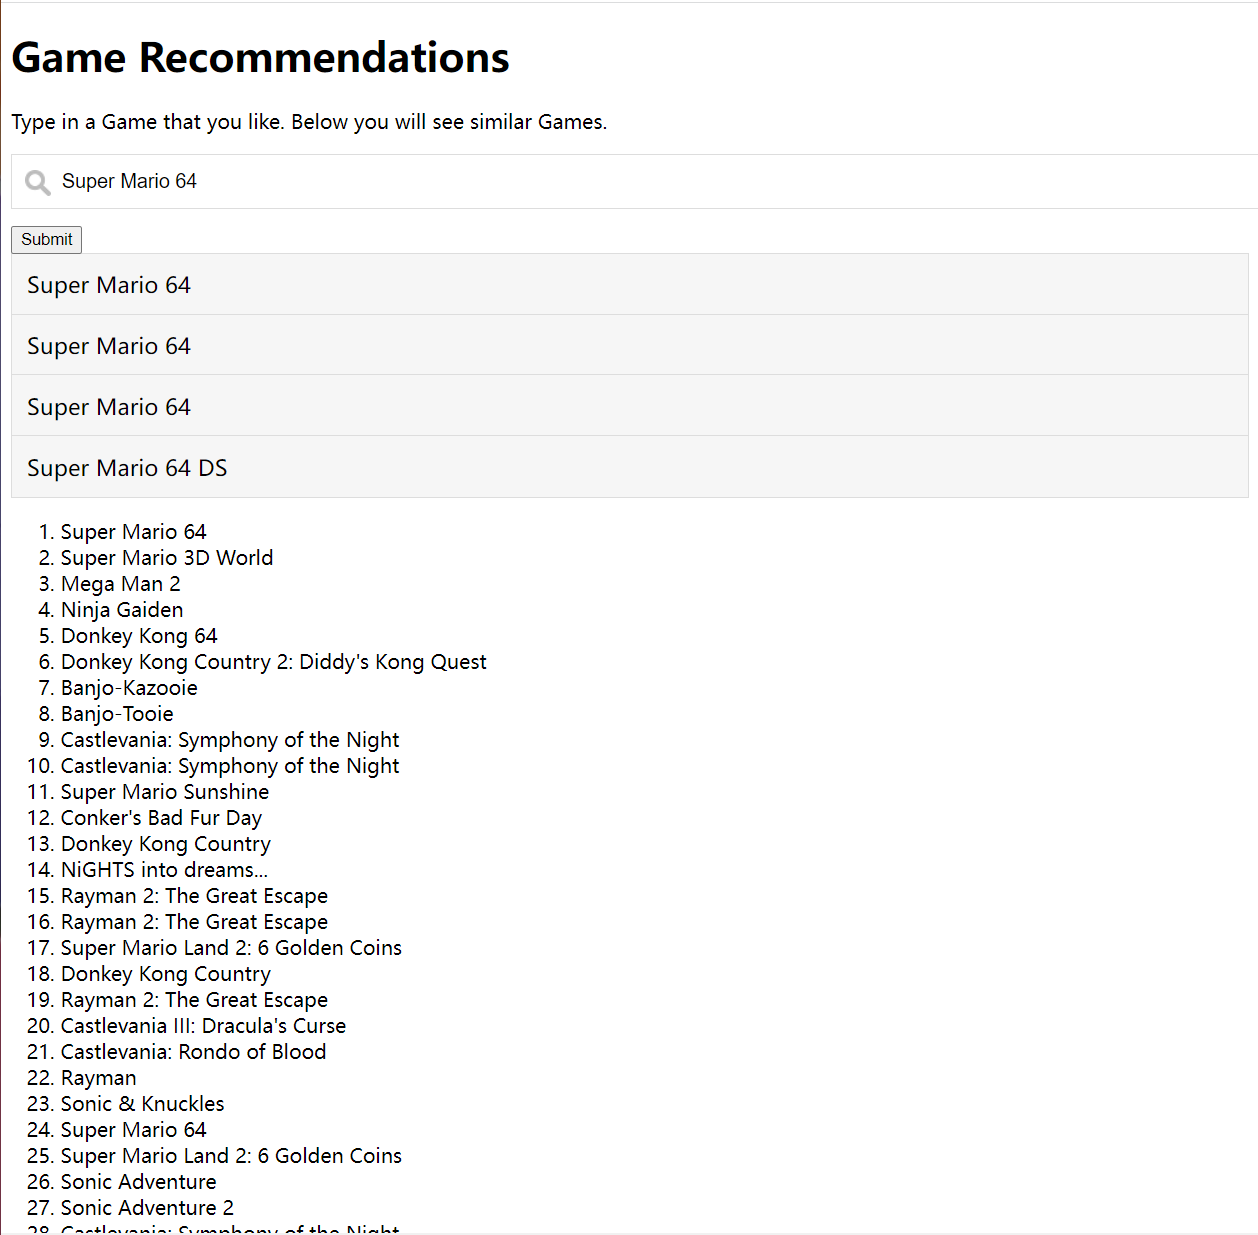

There are also a lot of extra works waiting to do for game recommendation:
1. In data cleaning, there're same name but different platform games are not processed. However, because the platform is a term for K-mean. So It also help people to choice game when they pay more attention to the platforms of game
2. There're some java script bugs should be fixed such as the difference between preview and IDE. Some function works in IDE but failed in preview.
3. More Genre is a big help to increase the accurancy of K-mean. We can find datasets with more genres and merge it with the orginal data.